# Fake News Detection - Complete Project

This notebook includes:
- Data Preprocessing
- Simple Model (Naive Bayes with TF-IDF)
- Advanced Model (DistilBERT)
- Evaluation on FakeNewsCorpus and LIAR Dataset
- Saving & Loading Models

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import nltk
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Step 2: Load and Explore Data

In [2]:
df = pd.read_csv(r"D:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\code\preprocessed_news.csv")

In [3]:
df.head()

,content,type,processed_content
0,The Mainstream Media has always been a Propaga...,fake,mainstream media alway propaganda tool establi...
1,Could Islam Destroy America?\n\nHeadline: Bitc...,fake,could islam destroy america headlin bitcoin bl...
2,"SC barber, customers fire on, kill robbery sus...",fake,sc barber custom fire kill robberi suspect kid...
3,Camping Bus\n\n% of readers think this story i...,fake,camp bu reader think stori fact add two cent h...
4,"Take heart, Sanders supporters. We’re down, bu...",political,take heart sander support berni difficult path...


In [4]:
print(df.columns)

Index(['content', 'type', 'processed_content'], dtype='object')


### Step 3: Preprocessing & Label Mapping

In [5]:
label_mapping = {
    'fake': 'fake', 'political': 'fake', 'conspiracy': 'fake', 'bias': 'fake',
    'satire': 'fake', 'clickbait': 'fake', 'junksci': 'fake', 'unreliable': 'fake',
    'hate': 'fake', 'unknown': 'fake', 'rumor': 'fake', 'reliable': 'reliable'
}
df['binary_label'] = df['type'].map(label_mapping)


### Step 4: Simple Baseline Model (TF-IDF + Naive Bayes)

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)

model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('nb', MultinomialNB())
])
model.fit(train_df['content'], train_df['binary_label'])
preds = model.predict(val_df['content'])
print(classification_report(val_df['binary_label'], preds))


              precision    recall  f1-score   support

        fake       0.88      0.99      0.93    124302
    reliable       0.96      0.55      0.70     38241

    accuracy                           0.89    162543
   macro avg       0.92      0.77      0.82    162543
weighted avg       0.90      0.89      0.88    162543



### Step 5: Save Simple Model

In [7]:
joblib.dump(model, 'simple_model.joblib')

['simple_model.joblib']

### Step 6: Load Pretrained DistilBERT Advanced Model

In [8]:
import torch
print("Torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


Torch: 2.5.1+cu121
CUDA: 12.1
CUDA available: True
GPU: NVIDIA GeForce GTX 1660 Ti


In [9]:
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

d:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Step 1: Get total rows
n_rows = sum(1 for _ in open(r'D:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\code\preprocessed_news.csv', 'r', encoding='utf-8', errors='ignore')) - 1
print(f"Total rows in dataset: {n_rows}")

Total rows in dataset: 20671771


In [11]:
#  Step 2: Get available RAM
import psutil
ram_gb = psutil.virtual_memory().available / 1e9
print(f"Available system RAM: {ram_gb:.2f} GB")

Available system RAM: 4.22 GB


In [12]:
#  Step 3: Estimate optimal chunk size
if ram_gb >= 16:
    chunk_size = int(n_rows / 10)
elif 8 <= ram_gb < 16:
    chunk_size = int(n_rows / 20)
else:
    chunk_size = int(n_rows / 40)

print(f"Recommended chunk size: {chunk_size}")

Recommended chunk size: 516794


In [13]:
from transformers import logging
logging.set_verbosity_error()

In [14]:
# Safety check
import os
assert not os.path.exists("torch.py"), "You have a file named 'torch.py' — rename it to avoid import conflicts."

In [15]:
# Parameters
super_chunk_size = 516_794/2
sub_chunk_parts = 5
sub_chunk_size = super_chunk_size // sub_chunk_parts

In [16]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
#  Dataset class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

In [18]:
#  Tokenizer function
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize_texts(texts, max_length=64):
    return tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

In [19]:
# Function to save model and tokenizer
def save_model_and_tokenizer(model, tokenizer, super_chunk_num, sub_i):
    model.save_pretrained(f'./saved_advanced_model_sc{super_chunk_num}_sub{sub_i}')
    tokenizer.save_pretrained(f'./saved_advanced_model_sc{super_chunk_num}_sub{sub_i}')

# Training loop
def train_on_chunks(file_path):
    reader = pd.read_csv(file_path, chunksize=super_chunk_size)
    super_chunk_num = 1

    for super_chunk in reader:
    
        sub_chunks = np.array_split(super_chunk, sub_chunk_parts)

        for sub_i, chunk in enumerate(sub_chunks, start=1):
            


            chunk['label'] = chunk['type'].map({'fake': 0, 'political': 1})
            chunk = chunk.dropna(subset=['label'])
            chunk['label'] = chunk['label'].astype(int)

            if chunk.empty:
                print(f"Skipped Sub-Chunk {sub_i} (no valid rows)")
                continue

            texts = chunk['content'].astype(str).tolist()
            labels = torch.tensor(chunk['label'].values)
            encodings = tokenize_texts(texts)

            try:
                train_idx, test_idx = train_test_split(
                    np.arange(len(labels)),
                    test_size=0.2,
                    stratify=labels,
                    random_state=42
                )
            except ValueError as e:
                print(f"Skipped Sub-Chunk {sub_i} (split error: {e})")
                continue

            train_dataset = NewsDataset({k: v[train_idx] for k, v in encodings.items()}, labels[train_idx])
            test_dataset = NewsDataset({k: v[test_idx] for k, v in encodings.items()}, labels[test_idx])

            model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
            model.to(device)

            training_args = TrainingArguments(
                output_dir=f'./results_sc{super_chunk_num}_sub{sub_i}',
                num_train_epochs=1,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                warmup_steps=50,
                weight_decay=0.01,
                logging_dir=f'./logs_sc{super_chunk_num}_sub{sub_i}',
                logging_steps=1000,
                disable_tqdm=True,
                fp16=torch.cuda.is_available()
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=test_dataset
            )

            trainer.train()
            predictions = trainer.predict(test_dataset)
            pred_labels = np.argmax(predictions.predictions, axis=1)

            print(f"\nTraining Completed")
            
            # Save the model and tokenizer after training
            save_model_and_tokenizer(model, tokenizer, super_chunk_num, sub_i)
            
            # Print classification report ONLY for first sub-chunk
            if sub_i == 1:
                print("\n Final Classification Report :")
                print(classification_report(labels[test_idx], pred_labels, target_names=['fake', 'political']))

            # Ask user if they want to run next sub-chunk
            choice = input(f"Do you want to run the next sub-chunk? (y/n): ").strip().lower()
            if choice != 'y':
                print("Stopping by user request.")
                return

        # Ask user if they want to run next super chunk
        choice = input(f"\nFinished Super Chunk {super_chunk_num}. Run next super chunk? (y/n): ").strip().lower()
        if choice != 'y':
            print("Training stopped by user.")
            break

        super_chunk_num += 1

# start training
file_path = r"D:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\code\preprocessed_news.csv"
train_on_chunks(file_path)

d:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\.venv\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\sindh\AppData\Local\Temp\ipykernel_6932\1706702242.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['label'] = chunk['label'].astype(int)


{'loss': 0.1339, 'grad_norm': 1.6973395347595215, 'learning_rate': 5.700934579439252e-06, 'epoch': 0.8928571428571429}
{'train_runtime': 562.219, 'train_samples_per_second': 31.867, 'train_steps_per_second': 1.992, 'train_loss': 0.12865217328071593, 'epoch': 1.0}

Training Completed

 Final Classification Report :
              precision    recall  f1-score   support

        fake       0.99      0.92      0.96      1481
   political       0.96      1.00      0.98      2999

    accuracy                           0.97      4480
   macro avg       0.98      0.96      0.97      4480
weighted avg       0.97      0.97      0.97      4480

Stopping by user request.


## 🔹 LIAR Dataset: Cross-Domain Evaluation
### Step 1: Import Libraries

In [20]:
from sklearn.metrics import confusion_matrix

### Step 2: Load & Preprocess LIAR Dataset

In [21]:
# Step 1: Load LIAR Dataset (test.tsv)
column_names = [
    "id", "label", "statement", "subject", "speaker", "job_title", "state",
    "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"
]
liar_test = pd.read_csv(
    "D:/1_LUT_Masters/2 Spring 2025/Intelligent Systems/Project/dataset/liar_dataset/test.tsv",
    sep="\t", names=column_names, header=None)

In [22]:
print("LIAR Dataset Preview:")
print(liar_test.head())

🔎 LIAR Dataset Preview:
           id       label                                          statement  \
0  11972.json        true  Building a wall on the U.S.-Mexico border will...   
1  11685.json       false  Wisconsin is on pace to double the number of l...   
2  11096.json       false  Says John McCain has done nothing to help the ...   
3   5209.json   half-true  Suzanne Bonamici supports a plan that will cut...   
4   9524.json  pants-fire  When asked by a reporter whether hes at the ce...   

                                             subject  \
0                                        immigration   
1                                               jobs   
2                    military,veterans,voting-record   
3  medicare,message-machine-2012,campaign-adverti...   
4  campaign-finance,legal-issues,campaign-adverti...   

                            speaker             job_title      state  \
0                        rick-perry              Governor      Texas   
1             

In [23]:
# Print column names
print("LIAR Dataset Columns:")
print(liar_test.columns.tolist())

LIAR Dataset Columns:
['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']


In [25]:
print(liar_test.columns.tolist())#  Step 3: Clean and Map Labels to Binary (Fake vs Reliable)
label_mapping = {
    "true": "reliable",
    "mostly-true": "reliable",
    "half-true": "fake",
    "barely-true": "fake",
    "false": "fake",
    "pants-fire": "fake"
}

liar_test["type"] = liar_test["label"].map(label_mapping)
liar_test["content"] = liar_test["statement"]
liar_test = liar_test.dropna(subset=["content", "type"])
liar_test["binary_label"] = liar_test["type"].map({"fake": 0, "reliable": 1})

print("\n Cleaned and Binary Mapped LIAR Test Data:")
print(liar_test[["label", "type", "binary_label"]].head())

['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']

✅ Cleaned and Binary Mapped LIAR Test Data:
        label      type  binary_label
0        true  reliable             1
1       false      fake             0
2       false      fake             0
3   half-true      fake             0
4  pants-fire      fake             0


In [26]:
cols = ["id", "label", "statement", "subject", "speaker", "job_title", "state",
        "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]
liar_test = pd.read_csv(r"D:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\dataset\liar_dataset\test.tsv", sep="\t", names=cols, header=None)
liar_test['text'] = liar_test['statement']
liar_test['label'] = liar_test['label'].map({
    'true': 1, 'mostly-true': 1,
    'half-true': 0, 'barely-true': 0, 'false': 0, 'pants-fire': 0
})
liar_test.dropna(subset=["text", "label"], inplace=True)


### Step 3: Evaluate Saved Simple and Advanced Model on LIAR Dataset

In [27]:
# Load model
simple_model = joblib.load("simple_model.joblib")

In [31]:


# Step 1: Load LIAR Dataset (test.tsv)
column_names = [
    "id", "label", "statement", "subject", "speaker", "job_title", "state",
    "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"
]
liar_test = pd.read_csv(
    "D:/1_LUT_Masters/2 Spring 2025/Intelligent Systems/Project/dataset/liar_dataset/test.tsv",
    sep="\t", names=column_names, header=None)

# Step 2: Label Mapping
label_map_text = {
    "true": "reliable",
    "mostly-true": "reliable",
    "half-true": "fake",
    "barely-true": "fake",
    "false": "fake",
    "pants-fire": "fake"
}

# Create required columns
liar_test["content"] = liar_test["statement"]
liar_test["type"] = liar_test["label"].map(label_map_text)
liar_test.dropna(subset=["content", "type"], inplace=True)

# Convert to binary
liar_test["binary_label"] = liar_test["type"].map({"fake": 0, "reliable": 1})
liar_test.dropna(subset=["binary_label"], inplace=True)

print("Final label distribution:")
print(liar_test["binary_label"].value_counts())

#  Step 3: Load Simple and Advanced Models
simple_model = joblib.load("simple_model.joblib")

tokenizer = DistilBertTokenizerFast.from_pretrained("saved_advanced_model_sc1_sub1")
advanced_model = DistilBertForSequenceClassification.from_pretrained("saved_advanced_model_sc1_sub1")
advanced_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
advanced_model.to(device)

#  Step 4: Evaluation Functions
def evaluate_simple(model, df):
    preds = model.predict(df["content"])

    y_true = df["binary_label"].astype(int)
    y_pred = pd.Series(preds).map({"fake": 0, "reliable": 1}).astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, labels=[0, 1], target_names=["fake", "reliable"])

    return acc, precision, recall, f1, cm, report

def evaluate_advanced(model, tokenizer, df):
    texts = df["content"].astype(str).tolist()
    labels = df["binary_label"].astype(int).tolist()

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", pos_label=1)
    cm = confusion_matrix(labels, preds)
    report = classification_report(labels, preds, labels=[0, 1], target_names=["fake", "reliable"])

    return acc, precision, recall, f1, cm, report

#  Step 5: Run Evaluations
print("\nSimple Model Evaluation on LIAR Dataset")
s_acc, s_prec, s_rec, s_f1, s_cm, s_report = evaluate_simple(simple_model, liar_test)
print(s_report)
print("Confusion Matrix:\n", s_cm)

print("\nAdvanced Model Evaluation on LIAR Dataset (DistilBERT)")
a_acc, a_prec, a_rec, a_f1, a_cm, a_report = evaluate_advanced(advanced_model, tokenizer, liar_test)
print(a_report)
print("Confusion Matrix:\n", a_cm)

# Step 6: Comparison Table
summary = pd.DataFrame({
    "Model": ["Simple (Naive Bayes)", "Advanced (DistilBERT)"],
    "Accuracy": [s_acc, a_acc],
    "Precision": [s_prec, a_prec],
    "Recall": [s_rec, a_rec],
    "F1 Score": [s_f1, a_f1]
})
print("\n Comparison Table")
print(summary)

# 📦 Optional: Save results
summary.to_csv("liar_model_results.csv", index=False)


✅ Final label distribution:
binary_label
0    818
1    449
Name: count, dtype: int64

📊 Simple Model Evaluation on LIAR Dataset
              precision    recall  f1-score   support

        fake       0.65      1.00      0.78       818
    reliable       0.62      0.01      0.02       449

    accuracy                           0.65      1267
   macro avg       0.64      0.50      0.40      1267
weighted avg       0.64      0.65      0.51      1267

Confusion Matrix:
 [[815   3]
 [444   5]]

📊 Advanced Model Evaluation on LIAR Dataset (DistilBERT)
              precision    recall  f1-score   support

        fake       1.00      0.00      0.00       818
    reliable       0.35      1.00      0.52       449

    accuracy                           0.36      1267
   macro avg       0.68      0.50      0.26      1267
weighted avg       0.77      0.36      0.19      1267

Confusion Matrix:
 [[  1 817]
 [  0 449]]

✅ Comparison Table
                   Model  Accuracy  Precision    Recall 

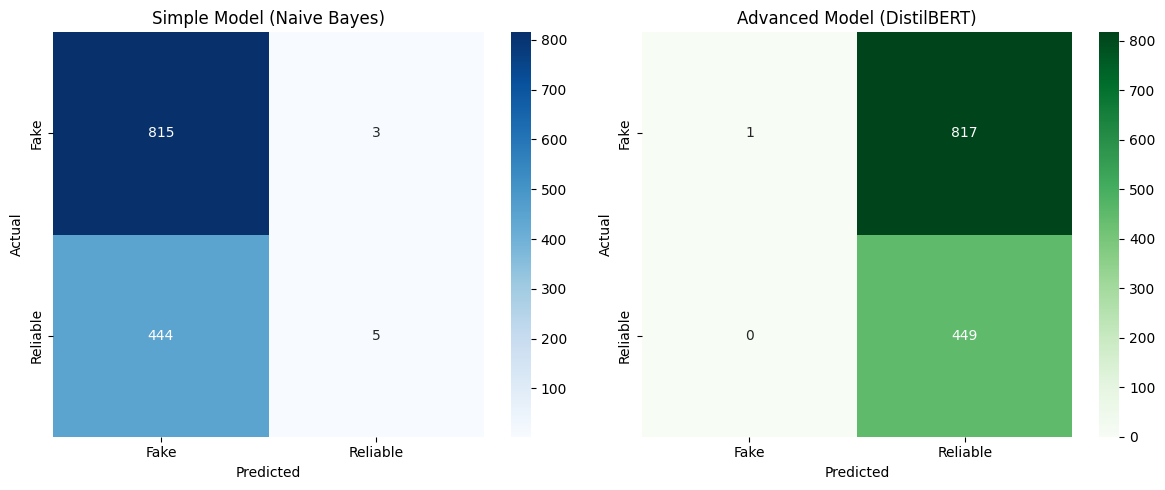

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrices
simple_cm = [[815, 3],
             [444, 5]]

advanced_cm = [[1, 817],
               [0, 449]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot simple model confusion matrix
sns.heatmap(simple_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Simple Model (Naive Bayes)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Fake', 'Reliable'])
axes[0].set_yticklabels(['Fake', 'Reliable'])

# Plot advanced model confusion matrix
sns.heatmap(advanced_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Advanced Model (DistilBERT)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Fake', 'Reliable'])
axes[1].set_yticklabels(['Fake', 'Reliable'])

plt.tight_layout()
plt.show()


### Step 4: Training with Hugging Face Trainer on LIAR Dataset

In [ ]:
#  Step 2: Clean and label map
label_map = {
    "true": 1,
    "mostly-true": 1,
    "half-true": 0,
    "barely-true": 0,
    "false": 0,
    "pants-fire": 0
}
liar_test["label"] = liar_test["label"].map(label_map)
liar_test.dropna(subset=["statement", "label"], inplace=True)

#  Step 3: Split into train/val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(liar_test, test_size=0.2, stratify=liar_test["label"], random_state=42)

#  Step 4: Dataset class
class LiarDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.label)

#  Step 5: Tokenizer + Datasets
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_dataset = LiarDataset(train_df["statement"].tolist(), train_df["label"].tolist(), tokenizer)
val_dataset = LiarDataset(val_df["statement"].tolist(), val_df["label"].tolist(), tokenizer)

#  Step 6: Load and Train DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./liar_test_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs_liar_test"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

#  Step 7: Save the fine-tuned model
model.save_pretrained("liar_test_finetuned_model")
tokenizer.save_pretrained("liar_test_finetuned_model")
print(" Model and tokenizer saved!")


{'train_runtime': 96.1164, 'train_samples_per_second': 31.618, 'train_steps_per_second': 1.998, 'train_loss': 0.5525629123051962, 'epoch': 3.0}
✅ Model and tokenizer saved!


### Step 5: For Liar dataset Load Fine-Tuned Model and Evaluate

In [41]:
# === Step 1: Reload the fine-tuned model ===
model_path = "liar_test_finetuned_model"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# === Step 3: Preprocessing ===
texts = df["statement"].astype(str).tolist()
labels = df["label"].astype(int).tolist()

# === Step 4: Tokenize ===
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64)
inputs = {k: v.to(device) for k, v in inputs.items()}

# === Step 5: Prediction ===
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# === Step 6: Evaluation ===
acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', pos_label=1)
cm = confusion_matrix(labels, preds)
report = classification_report(labels, preds, target_names=["fake", "reliable"])

print("\n Final Evaluation Report on test.tsv")
print(report)




📊 Final Evaluation Report on test.tsv
              precision    recall  f1-score   support

        fake       0.87      0.87      0.87       818
    reliable       0.77      0.76      0.76       449

    accuracy                           0.83      1267
   macro avg       0.82      0.81      0.82      1267
weighted avg       0.83      0.83      0.83      1267



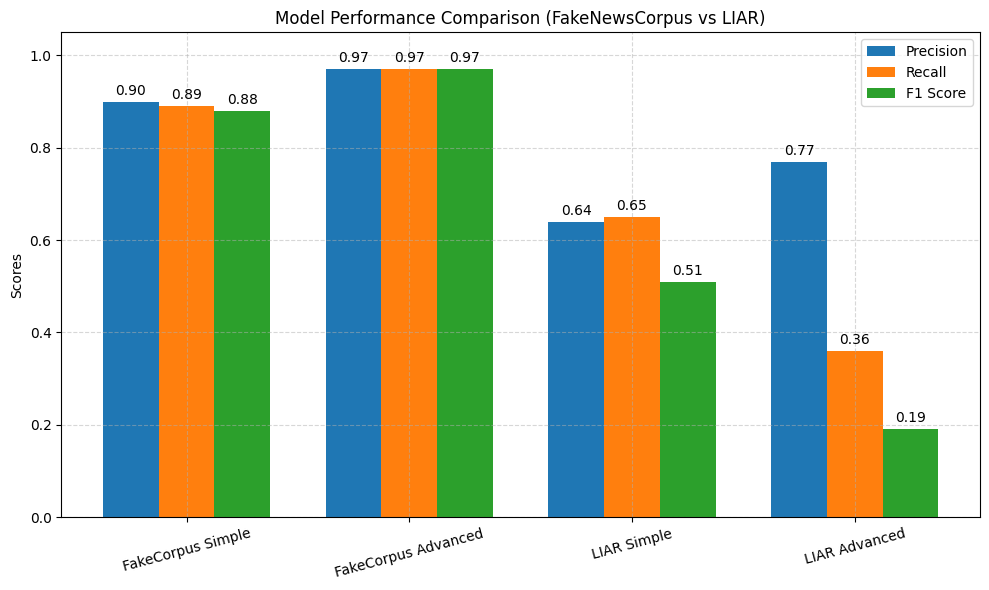

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# === Updated Classification Metrics ===
scores = {
    "FakeCorpus Simple": {"precision": 0.90, "recall": 0.89, "f1": 0.88},   # weighted avg
    "FakeCorpus Advanced": {"precision": 0.97, "recall": 0.97, "f1": 0.97}, # weighted avg
    "LIAR Simple": {"precision": 0.64, "recall": 0.65, "f1": 0.51},         # weighted avg
    "LIAR Advanced": {"precision": 0.77, "recall": 0.36, "f1": 0.19}        # weighted avg
}

# === Plot Settings ===
labels = list(scores.keys())
precision_scores = [scores[m]["precision"] for m in labels]
recall_scores = [scores[m]["recall"] for m in labels]
f1_scores = [scores[m]["f1"] for m in labels]

x = np.arange(len(labels))
width = 0.25

# === Create Grouped Bar Chart ===
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precision_scores, width, label='Precision')
ax.bar(x, recall_scores, width, label='Recall')
ax.bar(x + width, f1_scores, width, label='F1 Score')

# === Labels and Legends ===
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison (FakeNewsCorpus vs LIAR)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.set_ylim([0.0, 1.05])  # Increased from 1.0 to 1.05
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# === Annotate Bars ===
for i in range(len(labels)):
    ax.text(x[i] - width, precision_scores[i] + 0.015, f"{precision_scores[i]:.2f}", ha='center')
    ax.text(x[i], recall_scores[i] + 0.015, f"{recall_scores[i]:.2f}", ha='center')
    ax.text(x[i] + width, f1_scores[i] + 0.015, f"{f1_scores[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()
